In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ultralytics
import kornia.geometry

/Users/joe/opt/anaconda3/envs/em/lib/python3.9/site-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:

import electricmayhem.whitebox as em
from electricmayhem.blackbox import BlackBoxPatchTrainer

[WARNING 12-27 19:36:12] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [3]:
COCO_CLASSES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench','bird', 'cat',
                'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
                'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
                'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
                'clock', 'vase', 'scissors', 'teddy bear', 'hair drier','toothbrush']

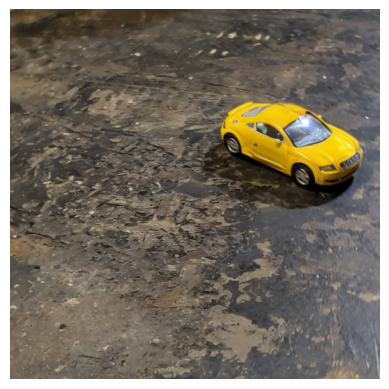

In [4]:
x = em.load_to_tensor("data/toycar/medium_distance_arc/057.png")
em.plot(x)

In [5]:
import electricmayhem.blackbox
electricmayhem.blackbox._augment.augment_image(x).shape

torch.Size([3, 640, 640])

In [6]:
model = ultralytics.YOLO("yolov8n.pt").model.eval()

In [7]:
def detect_func(img, return_raw=False, **kwargs):
    img = kornia.geometry.transform.resize(img, (640,640))
    model_outputs = model(img.unsqueeze(0))[0]
    class_probs = model_outputs[:,4:,:]
    maxval = torch.max(class_probs).item()
    if return_raw:
        return [int(maxval>0.25),maxval]
    else:
        return maxval

In [8]:
detect_func(x)

0.8437720537185669

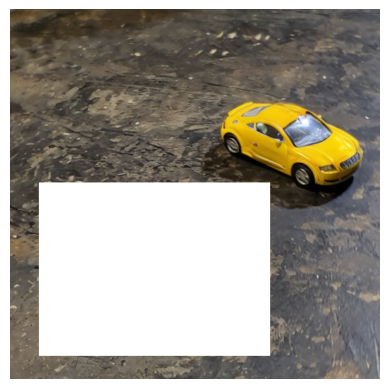

In [9]:
mask = torch.zeros_like(x)
mask[:,300:600,50:450] += 1
em.plot(x*(1-mask) + mask)

In [10]:
def eval_func(writer, counter, img, mask, perturbation, **kwargs):
    pert = kornia.geometry.transform.resize(perturbation, (640,640))
    x = img*(1-mask) + mask*pert
    detections = model(x.unsqueeze(0))
    detections_converted = em._yolo.convert_ultralytics_to_v5_format(detections[0])[0]
    fig = em._yolo.plot_detections(x.unsqueeze(0), detections_converted, 0, classnames=COCO_CLASSES)
    writer.add_figure("detections", fig, global_step=counter)


In [11]:
d = 40 # 80 #20
perturbation = torch.tensor(np.random.uniform(0, 1, size=(3,d,d)).astype(np.float32))
foo = perturbation.clone().detach().numpy()
trainer = BlackBoxPatchTrainer(
    x,
    mask,
    mask,
    detect_func,
    "logs/09_d_40_q_50/",
    perturbation=perturbation,
    num_augments=1, # number of augmentations to test each random direction under
    q=50, #100, # number of random directions per step
    beta=0.1, # RGF smoothing parameter
    reduce_mask=False,
    #tr_thresh=1, # transform robustness threshold for mask reduction. set high to skip that step for this example
    eval_augments=50, # number of random augmentations to use for evaluation
    use_scores=True, # use soft outputs of the model rather than hard decisions
    eval_func=eval_func,
    extra_params={"perturbation_size":d},
    aug_params={"scale":(0.99,1.01), "blur":[0], "rotate":0, "angle":0, "translate":0, "gamma":(1,1.1),
               "perspective_scale":0}
)

In [ ]:
#trainer.fit(budget=10000, lrs=[1e5, 1e4, 1000., 100., 10., 1.])
trainer.fit(budget=100000, lrs=[1e5, 1e4, 1000., 100., 10., 1.])

 50%|████████████████████████████████████████▌                                        | 50032/100000 [16:32:30<900:58:40, 64.91s/it]